# Flux calibration: scaling a model spectrum to photometric fluxes

Photometric and spectroscopic measurements of directly imaged planets typically provide the flux contrast between the companion and star. To calibrate the contrast of the companion to an apparent magnitude or flux requires an absolute measurement of the stellar flux. This tutorial shows and example on how to scale a BT-NextGen model spectrum to the 2MASS magnitudes of PZ Tel A. We will then use the scaled spectrum to calculate synthetic fluxes for the VLT/NACO Mp filter.

## Getting started

We start by importing the required Python modules.

In [1]:
import numpy as np
import species
from IPython.display import Image

Next, we initiate the *species* workflow.

In [2]:
species.SpeciesInit()

Initiating species v0.3.1... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


And we create an instance of `Database` which provides read and write access to the HDF5 database.

In [3]:
database = species.Database()

We also create a tuple with the GAIA distance and uncertainty of PZ Tel A.

In [4]:
distance = (47.13, 0.13)  # (pc)

And a dictionary with the 2MASS magnitudes.

In [5]:
magnitudes = {'2MASS/2MASS.J':(6.856, 0.021),
              '2MASS/2MASS.H':(6.486, 0.049),
              '2MASS/2MASS.Ks':(6.366, 0.024)}

For simplicty, we also create a list of the filter names for later use.

In [6]:
filters = list(magnitudes.keys())

## Adding data of an individual object

We can store the distance and magnitudes of PZ Tel A in the database with the `add_object` method. This will also download a flux-calibrated spectrum of Vega and convert the magnitudes into fluxes.

In [7]:
database.add_object(object_name='PZ Tel A',
                    distance=distance,
                    app_mag=magnitudes,
                    spectrum=None)

Adding Vega spectrum... [DONE]
Adding filter: 2MASS/2MASS.J... [DONE]
Adding filter: 2MASS/2MASS.H... [DONE]
Adding filter: 2MASS/2MASS.Ks... [DONE]
Adding object: PZ Tel A
   - Distance (pc) = 47.13 +/- 0.13
   - 2MASS/2MASS.J:
      - Apparent magnitude = 6.86 +/- 0.02
      - Flux (W m-2 um-1) = 5.81e-12 +/- 1.12e-13
   - 2MASS/2MASS.H:
      - Apparent magnitude = 6.49 +/- 0.05
      - Flux (W m-2 um-1) = 2.98e-12 +/- 1.34e-13
   - 2MASS/2MASS.Ks:
      - Apparent magnitude = 6.37 +/- 0.02
      - Flux (W m-2 um-1) = 1.25e-12 +/- 2.76e-14


## Adding a grid of model spectra

We will also download the BT-NextGen spectra and add the spectra of a limited T<sub>eff</sub> range to the database. Later on, we will extract a spectrum from this grid and use it for the calibration.

In [8]:
database.add_model('bt-nextgen', teff_range=(4500., 5500.))

Unpacking BT-NextGen model spectra (368 MB)... [DONE]
Adding BT-NextGen model spectra... [DONE]                                         
Grid points stored in the database:
   - Teff = [4500. 4600. 4700. 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500.]
   - log(g) = [3. 4. 5.]
   - [Fe/H] = [0.  0.3 0.5]
Number of grid points per parameter:
   - teff: 11
   - logg: 3
   - feh: 3
Fix missing grid points with a linear interpolation:
Number of stored grid points: 99
Number of interpolated grid points: 0
Number of missing grid points: 0


## Adding a calibration spectrum

The calibration spectrum is extracted from the BT-NextGen model grid. To do so, we first create an instance of `ReadModel` and consider the full wavelength range of the spectra as they are stored in the database.

In [9]:
model = species.ReadModel('bt-nextgen', wavel_range=None)

Next, we interpolate the grid with the `get_model` method at the (approximate) effective temperature, surface gravity, and metallicity of PZ Tel A.

In [10]:
model_box = model.get_model({'teff': 5000., 'logg': 4., 'feh': 0.})

The method returns the data in a `ModelBox`. Let's have a look at the content with the `open_box` function.

In [11]:
model_box.open_box()

Opening ModelBox...
model = bt-nextgen
type = None
wavelength = [ 0.1         0.10002476  0.10004953 ... 49.97524871 49.98762282
 50.        ]
flux = [5.67567052e-07 4.12210439e-07 4.07441433e-07 ... 1.58742049e+01
 1.58593879e+01 1.58419862e+01]
parameters = {'teff': 5000.0, 'logg': 4.0, 'feh': 0.0}
quantity = flux


To store the calibration spectrum in the database, we either require a text file with the spectrum or a `numpy` array. Therefore, we simply create an array from the `wavelength` and `flux` attributes of the `ModelBox`.

In [12]:
cal_spectrum = np.column_stack((model_box.wavelength, model_box.flux))

Let's check if the shape of the array is as expected.

In [13]:
cal_spectrum.shape

(25103, 2)

Finally, we use the `add_calibration` method of `Database` to store the calibration spectrum in the database. The attribute of `tag` is later on used to select the calibration spectrum in the database.

In [14]:
database.add_calibration(tag='cal_spec',
                         filename=None,
                         data=cal_spectrum,
                         units={'wavelength': 'um', 'flux': 'w m-2 um-1'})

Adding calibration spectrum: cal_spec... [DONE]


## Fitting the 2MASS fluxes with the calibration spectrum

We will now scale the BT-NextGen spectrum to the 2MASS fluxes by fitting a scaling parameter. For this procedure, we use the functionalities of `FitSpectrum`, which is initiated by providing the database tag with the data of PZ Tel A, a list with the filters that are used, the database tag of the calibration spectrum, and a dictionary with the prior boundaries for the scaling parameter.

In [15]:
fit = species.FitSpectrum(object_name='PZ Tel A',
                          filters=filters,
                          spectrum='cal_spec',
                          bounds={'scaling': (0., 1e-18)})

The posterior distribution is now sampled with the `run_mcmc` method and the samples are stored in the database by the `tag` name. The MCMC ensemble sampler of [*emcee*](https://emcee.readthedocs.io/en/stable/) requires an initial guess for the scaling parameter. The guess should be somewhat comparable to $(radius/distance)^2$ (i.e. to scale the flux from the atmosphere surface to the observer) but the sampler will probably also find the maximum liklihood if the guess is not so close to the maximum likelihood (as long as the `bounds` range is sufficiently wide). We will run the MCMC with 200 walkers and 1000 steps per walker.

In [16]:
fit.run_mcmc(nwalkers=200,
             nsteps=1000,
             guess={'scaling': 1e-19},
             tag='pztel')

Running MCMC...


100%|██████████| 1000/1000 [00:30<00:00, 32.42it/s]


Mean acceptance fraction: 0.792
Integrated autocorrelation time = [0.96126598]


## Plotting the MCMC results

Let's have a look at the result from the MCMC. We first plot the evolution of the walkers to check if they converged.

In [17]:
species.plot_walkers(tag='pztel',
                     nsteps=None,
                     offset=(-0.2, -0.08),
                     output='walkers.png')

Plotting walkers: walkers.png... [DONE]


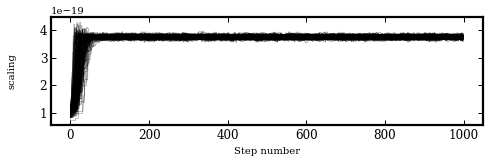

In [18]:
Image('walkers.png')

The walkers seem to have converged after ~50 steps already.

Next, we plot the posterior distribution of the scaling parameter to get the best-fit value and uncertainty. We exclude the first 200 steps as burnin of the MCMC sampling.

In [19]:
species.plot_posterior(tag='pztel',
                       burnin=200,
                       offset=(-0.3, -0.10),
                       title_fmt='.2e',
                       output='posterior.png')

Median sample:
   - scaling = 0.00
Maximum posterior sample:
   - scaling = 0.00
Plotting the posterior: posterior.png... [DONE]


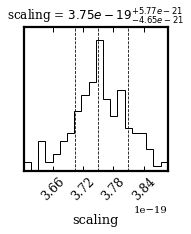

In [20]:
Image('posterior.png')

## Plotting the data and best-fit model

Finally, we will combine the MCMC spectra and the photometric data in a plot. For this, we require the data of PZ Tel A which are obtained with the `get_object` method of `Database`. The data are stored in an `ObjectBox`.

In [21]:
objectbox = database.get_object(object_name='PZ Tel A',
                                inc_phot=filters)

Getting object: PZ Tel A... [DONE]


We also select 30 random spectra from the posterior distribution with the `get_mcmc_spectra` method.

In [22]:
samples = database.get_mcmc_spectra(tag='pztel',
                                    burnin=200,
                                    random=30,
                                    wavel_range=(0.5, 10.),
                                    spec_res=None)

Getting MCMC spectra: 100%|██████████| 30/30 [00:00<00:00, 602.15it/s]


And we use `get_median_sample` to return a dictionary with the median values of the posterior distribution. In this case it only contains the `scaling` parameter.

In [23]:
median = database.get_median_sample(tag='pztel', burnin=200)

Let's have a look at the content of the dictionary.

In [24]:
print(median)

{'scaling': 3.7561166494901253e-19}


We will now read the calibration spectrum and apply the best-fit scaling value. We start by creating an instance of `ReadCalibration` and point the argument of `tag` to the stored spectrum in the database.

In [25]:
readcalib = species.ReadCalibration(tag='cal_spec',
                                    filter_name=None)

The spectrum is now read with the `get_spectrum` method by providing the dictionary with the model parameter.

In [26]:
spectrum = readcalib.get_spectrum(model_param=median)

We will also use the best-fit scaling to calculate synthetic photometry for the 2MASS filters, which will be compared with the true 2MASS fluxes.

In [27]:
synphot = species.multi_photometry(datatype='calibration',
                                   spectrum='cal_spec',
                                   filters=filters,
                                   parameters=median)

Calculating synthetic photometry... [DONE]


And we calculate the residuals between the 2MASS fluxes of PZ Tel A, which are stored in the `ObjectBox`, and the synthetic fluxes of the best-fit spectrum. The residuals are stored in a `ResidualsBox`.

In [28]:
residuals = species.get_residuals(datatype='calibration',
                                  spectrum='cal_spec',
                                  parameters=median,
                                  objectbox=objectbox,
                                  inc_phot=filters,
                                  inc_spec=False)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - 2MASS/2MASS.J: 2.29
   - 2MASS/2MASS.H: -1.89
   - 2MASS/2MASS.Ks: -1.44


Finally, all the boxes are combined in a list and provided as argument of `boxes` in the `plot_spectrum` function. We will also plot the 2MASS filter profiles and the residuals between the data and the best-fit model.

In [29]:
species.plot_spectrum(boxes=[samples, spectrum, objectbox, synphot],
                      filters=filters,
                      residuals=residuals,
                      plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                   {'ls': '-', 'lw': 1., 'color': 'black'},
                                   {'2MASS/2MASS.J': {'marker': 's', 'ms': 4., 'color': 'tomato', 'ls': 'none'},
                                    '2MASS/2MASS.H': {'marker': 's', 'ms': 4., 'color': 'tomato', 'ls': 'none'},
                                    '2MASS/2MASS.Ks': {'marker': 's', 'ms': 4., 'color': 'tomato', 'ls': 'none'}},
                                   None],
                      xlim=(1., 2.5),
                      ylim=(-1.5e-12, 1.1e-11),
                      ylim_res=(-7., 7.),
                      scale=('linear', 'linear'),
                      offset=(-0.35, -0.04),
                      figsize=(8., 4.5),
                      output='spectrum.png')

Plotting spectrum: spectrum.png... [DONE]


Let's have a look at the plot!

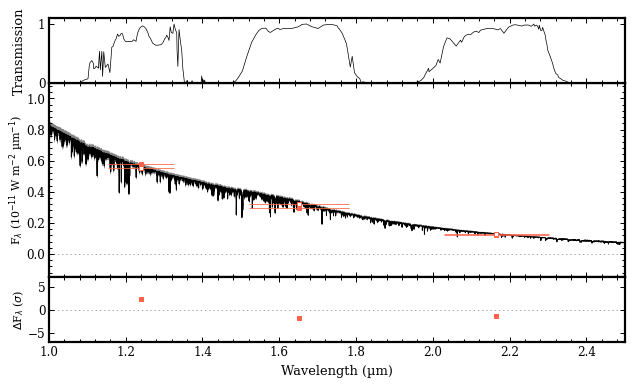

In [30]:
Image('spectrum.png')

## Photometric calibration

A measured contrast of PZ Tel B can now be converted into an apparent magnitude or flux by calculating synthetic photometry for PZ Tel A for any other filter. As an example, we will calculate the flux and magnitude for the VLT/NACO Mp filter. We start by creating again an instance of `ReadCalibration` but we now provide the filter name (as listed by the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/)) as argument of `filter_name`.

In [31]:
readcalib = species.ReadCalibration(tag='cal_spec',
                                    filter_name='Paranal/NACO.Mp')

Adding filter: Paranal/NACO.Mp... [DONE]


Next, we use the `get_flux` method and the dictionary with the best-fit scaling value to calculate the flux density of PZ Tel A in the NACO Mp filter.

In [32]:
flux = readcalib.get_flux(model_param=median)
print(f'Flux density (W m-2 um-1) = {flux[0]:.2e}')

Flux density (W m-2 um-1) = 6.12e-14


Or, we can calculate the apparent and absolute magnitude by using the `get_magnitude` method.

In [33]:
app_mag, abs_mag = readcalib.get_magnitude(model_param=median, distance=distance)
print(f'Apparent magnitude = {app_mag[0]:.2f}')
print(f'Absolute magnitude = {abs_mag[0]:.2f}')

Apparent magnitude = 6.37
Absolute magnitude = 3.00


We can also estimate the uncertainty on the magnitude by calculating synthetic magnitudes from the posterior samples. Here, we only select the last 100 samples of each walker to limit the computation time. We can plot the posterior distribution for the NACO Mp filter with the `plot_mag_posterior` function.

In [34]:
species.plot_mag_posterior(tag='pztel',
                           filter_name='Paranal/NACO.Mp',
                           burnin=900,
                           xlim=None,
                           output='mag_posterior.png')

Getting MCMC photometry: 100%|██████████| 20000/20000 [03:54<00:00, 85.23it/s] 

Plotting photometry samples: mag_posterior.png...

 [DONE]


Let's have a look at the plot!

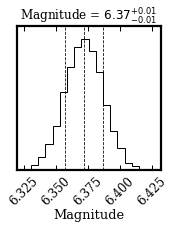

In [35]:
Image('mag_posterior.png')

## Spectral calibration

Similarly, for spectral calibration of the star, we can also resample the best-fit model spectrum to the wavelengths points of a (contrast) spectrum of a companion. We create again an instance of `ReadCalibration` but set the argument of `filter_name` to `None`.

In [36]:
readcalib = species.ReadCalibration(tag='cal_spec',
                                    filter_name=None)

Next, we resample the best-fit spectrum to the required wavelength points with `resample_spectrum`. The wavelengths points are provided as an array to the `wavel_points` parameter. In this example, we simply create 20 linearly-spaced points between 1 and 2 $\mu$m.

In [37]:
spec_box = readcalib.resample_spectrum(wavel_points=np.linspace(1., 2., 20),
                                       model_param=median,
                                       apply_mask=False)

Let's have a look at the content of the returned `SpectrumBox`!

In [38]:
spec_box.open_box()

Opening SpectrumBox...
spectrum = calibration
wavelength = [1.         1.05263158 1.10526316 1.15789474 1.21052632 1.26315789
 1.31578947 1.36842105 1.42105263 1.47368421 1.52631579 1.57894737
 1.63157895 1.68421053 1.73684211 1.78947368 1.84210526 1.89473684
 1.94736842 2.        ]
flux = [8.14217450e-12 7.43950188e-12 6.67000406e-12 6.21129509e-12
 5.73630952e-12 5.37992469e-12 5.00393477e-12 4.72416027e-12
 4.35542317e-12 4.04968813e-12 3.83276532e-12 3.56730086e-12
 3.36823635e-12 3.08273058e-12 2.76297746e-12 2.51230903e-12
 2.25936568e-12 2.02975750e-12 1.84593508e-12 1.69037787e-12]
error = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
name = cal_spec
simbad = None
sptype = None
distance = None
